In [1]:
import numpy as np
import matplotlib.pyplot as plt

import opendiff.materials as mat
import opendiff.solver as solver
import opendiff.perturbation as pert

from opendiff import set_log_level, log_level

solver.init_slepc()
set_log_level(log_level.warning)

# Material creation

In [2]:
fuel1 = [[1.5, 0.01, 0, 1, 0., 0.020, 202 * 1.60218e-19 * 1e6, 2.4],
         [0.4, 0.085, 0.135, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
fuel1_cr = [[1.5, 0.01, 0, 1, 0., 0.020, 202 * 1.60218e-19 * 1e6, 2.4],
            [0.4, 0.130, 0.135, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
fuel2 = [[1.5, 0.01, 0, 1, 0., 0.020, 202 * 1.60218e-19 * 1e6, 2.4],
         [0.4, 0.080, 0.135, 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
refl = [[2.0, 0.0, 0, 0, 0., 0.040, 202 * 1.60218e-19 * 1e6, 2.4],
        [0.3, 0.01, 0., 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
refl_cr = [[2.0, 0.0, 0, 0, 0., 0.040, 202 * 1.60218e-19 * 1e6, 2.4],
           [0.3, 0.055, 0., 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
void = [[1e10, 0., 0., 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4],
        [1e10, 0., 0., 0, 0., 0., 202 * 1.60218e-19 * 1e6, 2.4]]
all_mat = [fuel1, fuel1_cr, fuel2, refl, refl_cr, void]
mat_names = ["fuel1", "fuel1_cr", "fuel2", "refl", "refl_cr", "void"]
reac_names = ["D", "SIGA", "NU_SIGF", "CHI", "1", "2", "EFISS", "NU"]

mat_lib = mat.Materials(all_mat, mat_names, reac_names)

# Geometry and macrolib creation 

In [3]:
x = [0, 20*9*2]
pblm = ["refl", "fuel2", "fuel1", "fuel1", "fuel1_cr", "fuel1", "fuel1", "fuel1", "fuel1_cr"]
pblm += pblm[::-1]
print(pblm)

#we mesh it 
nb_cell_pmat = 20
pblm_meshed = []
for i in pblm: 
    pblm_meshed.extend([i]*nb_cell_pmat)
nb_cells = len(pblm_meshed)
pblm_meshed = [[pblm_meshed]]
x_mesh = np.linspace(x[0], x[1], nb_cells+1)
x_mean = (x_mesh[:-1] + x_mesh[1:])/2.
macrolib = mat.Macrolib(mat_lib, pblm_meshed)
nb_groups = macrolib.getNbGroups()


['refl', 'fuel2', 'fuel1', 'fuel1', 'fuel1_cr', 'fuel1', 'fuel1', 'fuel1', 'fuel1_cr', 'fuel1_cr', 'fuel1', 'fuel1', 'fuel1', 'fuel1_cr', 'fuel1', 'fuel1', 'fuel2', 'refl']


# Solver creation

In [4]:
s = solver.SolverFullSlepc(x_mesh, macrolib, 0., 0.)#zero flux albedo
s_star = solver.SolverFullSlepc(s)
s_star.makeAdjoint()

# Solve the problem

In [5]:
nb_eigen= len(x_mean)-1 # same for 50 
s.solve(nb_eigen_values=nb_eigen, inner_max_iter=500, tol=1e-10, tol_inner=1e-4)
s_star.solve(nb_eigen_values=nb_eigen, inner_max_iter=500, tol=1e-10, tol_inner=1e-4)
egval = s.getEigenValues()
egval_star = s_star.getEigenValues()
egvect = s.getEigenVectors()
egvect_star = s_star.getEigenVectors()


# Visualisation of the direct flux 

Text(0, 0.5, '$\\phi$ (U.A.)')

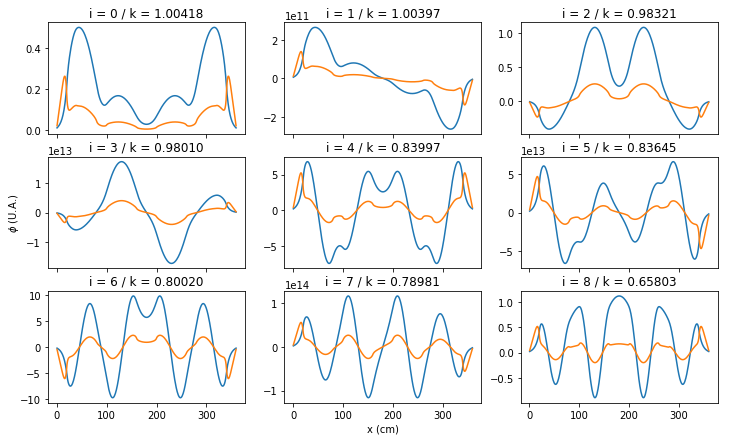

In [6]:
fig, axs = plt.subplots(3, 3, sharex=True, figsize=(12, 7))
for i in range(9):
    k = i % 3
    j = i // 3
    phi_i = egvect[i].reshape((nb_groups, nb_cells))
    phi_i = phi_i/phi_i.sum()*100
    axs[j, k].plot(x_mean, np.real(phi_i[0, :]))
    axs[j, k].plot(x_mean, np.real(phi_i[1, :]))
    axs[j, k].set_title(f"i = {i} / k = {egval[i]:.5f}")

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False,
                bottom=False, left=False, right=False)
plt.xlabel("x (cm)")
plt.ylabel("$\phi$ (U.A.)")

# Visualisation of the adjoint flux 

Text(0, 0.5, '$\\phi$ (U.A.)')

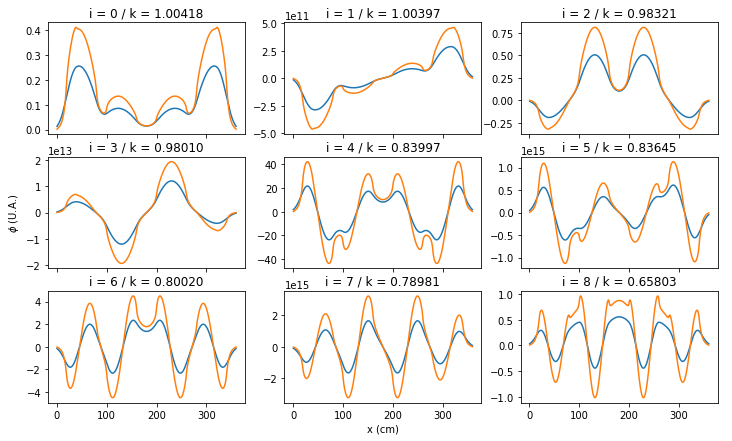

In [32]:
fig, axs = plt.subplots(3, 3, sharex=True, figsize=(12, 7))
for i in range(9):
    k = i % 3
    j = i // 3
    phi_i = egvect_star[i].reshape((nb_groups, nb_cells))
    phi_i = phi_i/phi_i.sum()*100
    axs[j, k].plot(x_mean, np.real(phi_i[0, :]))
    axs[j, k].plot(x_mean, np.real(phi_i[1, :]))
    axs[j, k].set_title(f"i = {i} / k = {egval_star[i]:.5f}")

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False,
                bottom=False, left=False, right=False)
plt.xlabel("x (cm)")
plt.ylabel("$\phi$ (U.A.)")

# Check biorthogonality and degenerated ev

In [33]:
print(nb_eigen)
set_log_level(log_level.info)
s.normPhiStarMPhi(s_star)

pert.handleDegeneratedEigenvalues(s, s_star, 1e-10)
pert.checkBiOrthogonality(s, s_star, 1e-10, False, True)

print(len(s.getEigenValues()))
print(len(s_star.getEigenValues()))

359
[2022-11-22 15:38:02.278] [info] New orthogonalisation with a group of 2 eigenvectors from 313 to 314
[2022-11-22 15:38:02.278] [info] New orthogonalisation with a group of 2 eigenvectors from 317 to 318
[2022-11-22 15:38:02.278] [info] New orthogonalisation with a group of 40 eigenvectors from 320 to 359
[2022-11-22 15:38:02.308] [info] New orthogonalisation with a group of 2 eigenvectors from 313 to 314
[2022-11-22 15:38:02.309] [info] New orthogonalisation with a group of 2 eigenvectors from 317 to 318
[2022-11-22 15:38:02.309] [info] New orthogonalisation with a group of 40 eigenvectors from 320 to 359
[2022-11-22 15:38:14.795] [info] Biorthogonality max test : 1.18e+02


False

# Modal expansion reconstruction  


In [35]:
print(mat_lib.getMaterial("fuel1_cr"))
mat_lib_pert = mat.Materials(mat_lib)
# sigr = mat_lib_pert.getValue("fuel1_cr", 1, "SIGR")*1.01
# print(sigr)
# mat_lib_pert.setValue("fuel1_cr", 1, "SIGR", sigr)
# print(mat_lib_pert.getMaterial("fuel1_cr"))

sigr = mat_lib_pert.getValue("fuel1", 2, "NU_SIGF")*1.01
print(sigr)
mat_lib_pert.setValue("fuel1", 2, "NU_SIGF", sigr)
print(mat_lib_pert.getMaterial("fuel1"))


# sigr = mat_lib_pert.getValue("fuel1", 1, "SIGR")*1.01
# print(sigr)
# mat_lib_pert.setValue("fuel1", 1, "SIGR", sigr)
# print(mat_lib_pert.getMaterial("fuel1"))


macrolib_pert = mat.Macrolib(mat_lib_pert, pblm_meshed)
s_pert = solver.SolverFullSlepc(x_mesh, macrolib_pert, 0., 0.)#zero flux albedo
s_recons = solver.SolverFullSlepc(s_pert)
s_pert.solve(nb_eigen_values=200, inner_max_iter=500, tol=1e-10, tol_inner=1e-4)
egval_pert = s_pert.getEigenValues()

[[1.5000000e+00 1.0000000e-02 0.0000000e+00 1.0000000e+00 3.2364036e-11
  2.4000000e+00 0.0000000e+00 2.0000000e-02 3.0000000e-02 0.0000000e+00]
 [4.0000000e-01 1.3000000e-01 1.3500000e-01 0.0000000e+00 3.2364036e-11
  2.4000000e+00 0.0000000e+00 0.0000000e+00 1.3000000e-01 5.6250000e-02]]
0.13635
[[1.5000000e+00 1.0000000e-02 0.0000000e+00 1.0000000e+00 3.2364036e-11
  2.4000000e+00 0.0000000e+00 2.0000000e-02 3.0000000e-02 0.0000000e+00]
 [4.0000000e-01 8.5000000e-02 1.3635000e-01 0.0000000e+00 3.2364036e-11
  2.4000000e+00 0.0000000e+00 0.0000000e+00 8.5000000e-02 5.6812500e-02]]
[2022-11-22 15:38:15.170] [info] Number of converged eigenpairs: 337


In [36]:
set_log_level(log_level.debug)
egvec_recons, egval_recons, a = pert.firstOrderPerturbation(s, s_star, s_recons, "PhiStarMPhi")
egvec_recons, egval_recons, a = pert.firstOrderPerturbation(s, s_star, s_recons, "power")

print(egval_recons)
print(egval_pert[0])
print(egval[0])

print("sens", 1e5*(egval_pert[0]-egval[0])/(egval[0]*egval_pert[0]))
print("sens recons", 1e5*(egval_recons-egval[0])/(egval[0]*egval_recons))
print("delta recons", 1e5*(egval_recons-egval_pert[0])/(egval_pert[0]*egval_recons))


s_pert.normPower()
s.normPower()
s_recons.normPower()

egvect_pert = s_pert.getEigenVector(0)
egvect = s.getEigenVector(0)
egvect_recons = s_recons.getEigenVector(0)


[2022-11-22 15:38:15.187] [info] Eigen value 0 = 1.01095 +- 1.19e-15
[2022-11-22 15:38:15.187] [info] Eigen value 1 = 1.01067 +- 9.09e-16
[2022-11-22 15:38:15.187] [info] Eigen value 2 = 0.99210 +- 1.15e-15
[2022-11-22 15:38:15.187] [info] Eigen value 3 = 0.98914 +- 9.97e-16
[2022-11-22 15:38:15.187] [info] Eigen value 4 = 0.84496 +- 8.80e-16
[2022-11-22 15:38:15.187] [info] Eigen value 5 = 0.84126 +- 1.20e-15
[2022-11-22 15:38:15.187] [info] Eigen value 6 = 0.80596 +- 9.94e-16
[2022-11-22 15:38:15.187] [info] Eigen value 7 = 0.79616 +- 1.48e-15
[2022-11-22 15:38:15.187] [info] Eigen value 8 = 0.66145 +- 1.12e-15
[2022-11-22 15:38:15.187] [info] Eigen value 9 = 0.64203 +- 1.29e-15
[2022-11-22 15:38:15.187] [info] Eigen value 10 = 0.60907 +- 1.03e-15
[2022-11-22 15:38:15.187] [info] Eigen value 11 = 0.58786 +- 1.38e-15
[2022-11-22 15:38:15.187] [info] Eigen value 12 = 0.52618 +- 1.12e-15
[2022-11-22 15:38:15.187] [info] Eigen value 13 = 0.47697 +- 1.15e-15
[2022-11-22 15:38:15.187] [inf

0.9676789018169708


Text(0, 0.5, '$a_i$ (U.A.)')

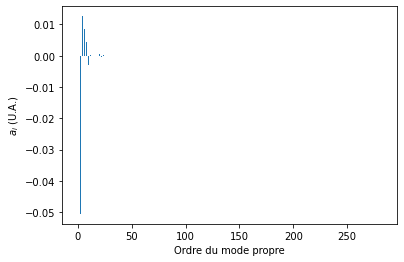

In [37]:
print(a[0])
a[0] -= 1
fig, ax = plt.subplots()
y_pos = np.arange(len(a))
ax.bar(y_pos, a)
ax.set_xlabel("Ordre du mode propre")
ax.set_ylabel("$a_i$ (U.A.)")

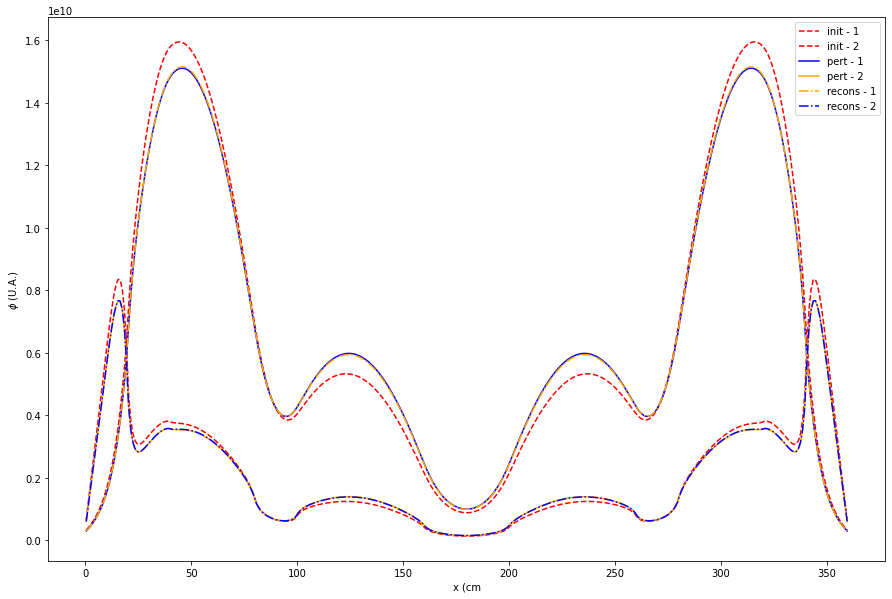

In [38]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(x_mean, egvect[0, 0, 0, :], "--", label="init - 1", color='red')
ax.plot(x_mean, egvect[1, 0, 0, :], "--", label="init - 2", color='red')

ax.plot(x_mean, egvect_pert[0, 0, 0, :], label="pert - 1", color='blue')
ax.plot(x_mean, egvect_pert[1, 0, 0, :], label="pert - 2", color='orange')
ax.plot(x_mean, egvect_recons[0, 0, 0, :], "-.", label="recons - 1", color='orange')
ax.plot(x_mean, egvect_recons[1, 0, 0, :], "-.", label="recons - 2", color='blue')

ax.set_xlabel("x (cm")
ax.set_ylabel("$\phi$ (U.A.)")
ax.legend()


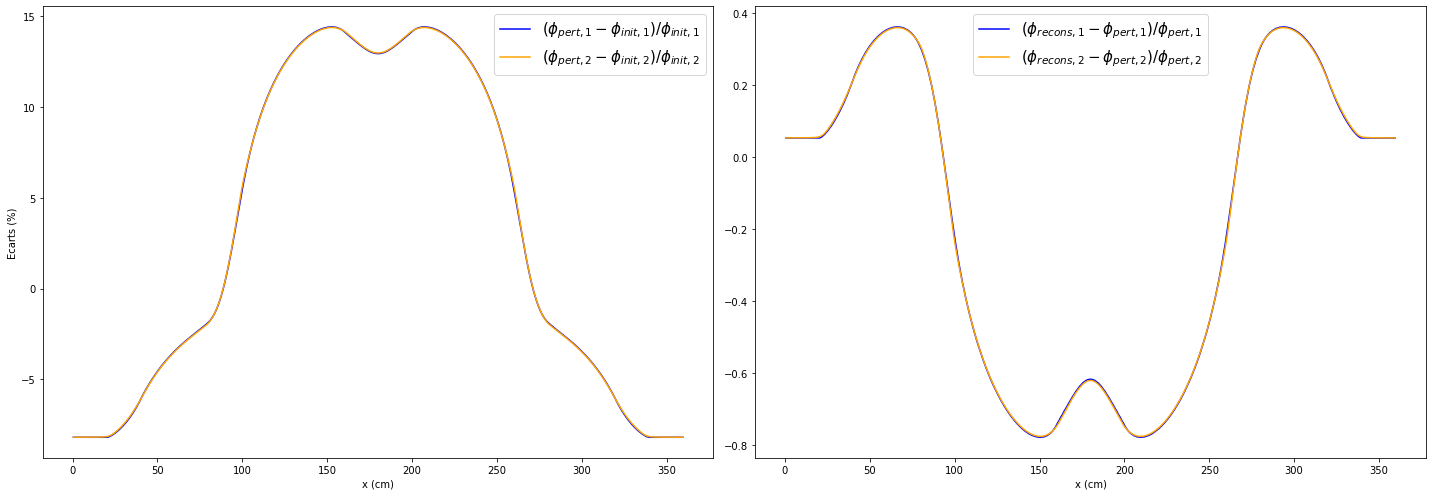

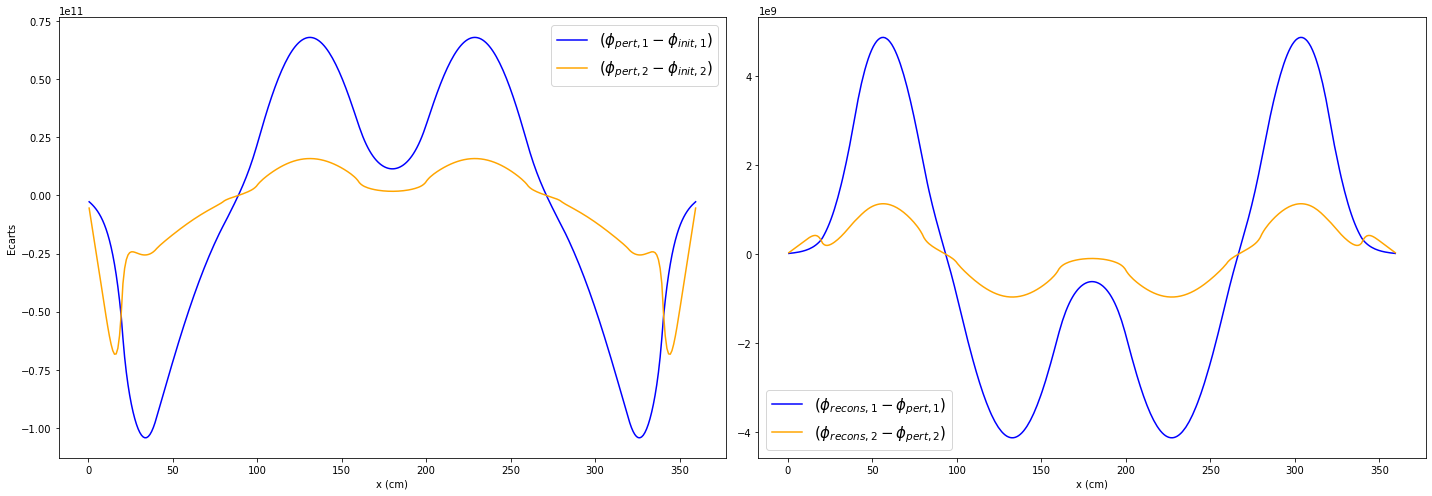

In [39]:

fig, ax = plt.subplots(1, 2, sharey=False, figsize=(20, 7))
ax[0].plot(x_mean, 100*(egvect_pert[0, 0, 0, :]-egvect[0, 0, 0, :]) / egvect[0, 0, 0, :],
        label="$(\phi_{pert,1} - \phi_{init,1}) / \phi_{init,1}}$", color='blue')
ax[0].plot(x_mean, 100*(egvect_pert[1, 0, 0, :]-egvect[1, 0, 0, :]) / egvect[1, 0, 0, :],
        label="$(\phi_{pert,2} - \phi_{init,2}) / \phi_{init,2}}$", color='orange')
ax[0].legend(fontsize=15)
ax[0].set_xlabel("x (cm)")
ax[0].set_ylabel("Ecarts (%)")

ax[1].plot(x_mean, 100*(egvect_recons[0, 0, 0, :]-egvect_pert[0, 0, 0, :]) / egvect_pert[0, 0, 0, :],
           label="$(\phi_{recons,1} - \phi_{pert,1}) / \phi_{pert,1}}$", color='blue')
ax[1].plot(x_mean, 100*(egvect_recons[1, 0, 0, :]-egvect_pert[1, 0, 0, :]) / egvect_pert[1, 0, 0, :],
        label="$(\phi_{recons,2} - \phi_{pert,2}) / \phi_{pert,2}}$", color='orange')
ax[1].legend(fontsize=15)
ax[1].set_xlabel("x (cm)")
fig.tight_layout()


fig, ax = plt.subplots(1, 2, sharey=False, figsize=(20, 7))
ax[0].plot(x_mean, 100*(egvect_pert[0, 0, 0, :]-egvect[0, 0, 0, :]),
           label="$(\phi_{pert,1} - \phi_{init,1}) $", color='blue')
ax[0].plot(x_mean, 100*(egvect_pert[1, 0, 0, :]-egvect[1, 0, 0, :]) ,
           label="$(\phi_{pert,2} - \phi_{init,2})$", color='orange')
ax[0].legend(fontsize=15)
ax[0].set_xlabel("x (cm)")
ax[0].set_ylabel("Ecarts")

ax[1].plot(x_mean, 100*(egvect_recons[0, 0, 0, :]-egvect_pert[0, 0, 0, :]) ,
           label="$(\phi_{recons,1} - \phi_{pert,1})$", color='blue')
ax[1].plot(x_mean, 100*(egvect_recons[1, 0, 0, :]-egvect_pert[1, 0, 0, :]) ,
           label="$(\phi_{recons,2} - \phi_{pert,2})$", color='orange')
ax[1].legend(fontsize=15)
ax[1].set_xlabel("x (cm)")
fig.tight_layout()

# fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20, 7))
# ax[0].plot(x_mean, 100*(egvect_pert[0, 0, 0, :]-egvect[0, 0, 0, :]),
#            label="$(\phi_{pert,1} - \phi_{init,1}) $", color='blue')
# ax[0].plot(x_mean, 100*(egvect_pert[1, 0, 0, :]-egvect[1, 0, 0, :]) ,
#            label="$(\phi_{pert,2} - \phi_{init,2})$", color='orange')
# ax[0].legend(fontsize=15)
# ax[0].set_xlabel("x (cm)")
# ax[0].set_ylabel("Ecarts")

# ax[1].plot(x_mean, 100*(egvect_recons[0, 0, 0, :]-egvect_pert[0, 0, 0, :]) ,
#            label="$(\phi_{recons,1} - \phi_{pert,1})$", color='blue')
# ax[1].plot(x_mean, 100*(egvect_recons[1, 0, 0, :]-egvect_pert[1, 0, 0, :]) ,
#            label="$(\phi_{recons,2} - \phi_{pert,2})$", color='orange')
# ax[1].legend(fontsize=15)
# ax[1].set_xlabel("x (cm)")
# fig.tight_layout()
